In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from splot.mapping import vba_choropleth, vba_legend, mapclassify_bin
from shapely.geometry import Point, Polygon, LineString
import libpysal.weights as sw 
from esda.moran import Moran_Local, Moran
from splot.esda import lisa_cluster, plot_local_autocorrelation, plot_moran
import warnings
import census
import us
import rasterio
warnings.simplefilter("ignore") 

In [11]:
parks=gpd.read_file('S:/376/Spring22/jkchap16/nyc_parks.zip')
parks = parks.to_crs(epsg='3857')
parks=parks[(parks['landuse']=='Neighborhood Park') | (parks['landuse']=='Community Park') |(parks['landuse']=='Nature Area') |(parks['landuse']=='Garden') | (parks['landuse']=='Flagship Park')]
parks=parks.reset_index().rename(columns={'index': 'park_subsection'})
parks['park_subsection']=parks['park_subsection'].astype(str)
parks['park_id']=parks['parknum'] + '_' + parks['park_subsection']
parks.head()

,park_subsection,feat_code,landuse,park_name,parknum,shape_area,shape_leng,source_id,status,sub_code,system,geometry,park_id
0,0,4910.0,Community Park,Commodore Barry Park,B021,4.153980e+04,829.420107,2.149100e+10,Updated,491050.0,None,"POLYGON ((-8235329.517 4967898.091, -8235332.6...",B021_0
1,1,4980.0,Neighborhood Park,Pierrepont Playground,B222,2.196049e+04,607.555193,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8237344.014 4967605.736, -8237344.2...",B222_1
2,2,4980.0,Neighborhood Park,Cobble Hill Park,B326,2.807908e+04,784.421990,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8237149.641 4966419.691, -8237149.6...",B326_2
3,3,4980.0,Community Park,Commodore Barry Park,B021,4.384161e+05,2672.710150,2.149800e+10,Unchanged,498000.0,None,"POLYGON ((-8235133.914 4967679.410, -8235133.3...",B021_3
4,10,4980.0,Community Park,Brooklyn Bridge Park,B431,1.995609e+06,18025.160510,2.149800e+10,Updated,498000.0,None,"POLYGON ((-8237031.726 4968770.973, -8237031.7...",B431_10


<AxesSubplot:>

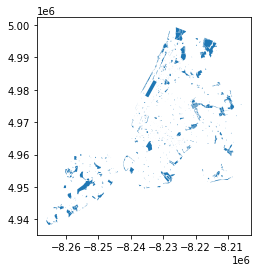

In [32]:
parks.plot()

# Length of trails

In [29]:
trails=gpd.read_file('S:/376/Spring22/jkchap16/Parks Trails.zip')
trails=trails.to_crs(epsg='3857')
trails.head()

,park_name,width_ft,class,surface,gen_topog,difficulty,date_date_,time_date_,trail_name,parkid,trailmarke,geometry
0,Ocean Breeze Park,12,ClassIV highly developed,Grasses,Level,2.0,2020-11-12,00:00:00.000,3K,R149,No,"LINESTRING (-8629470.764 4882302.282, -8629470..."
1,Pelham Bay Park,3,ClassII simple/minor developed,Dirt,Level,2.0,2020-11-12,00:00:00.000,Siwanoy Trail,None,No,"LINESTRING (-8629470.661 4882302.400, -8629470..."
2,Ocean Breeze Park,12,ClassIV highly developed,Grasses,Level,2.0,2020-11-12,00:00:00.000,4K and 5K - Loop B and 2K,None,No,"LINESTRING (-8629470.764 4882302.282, -8629470..."
3,Ocean Breeze Park,15,ClassIV highly developed,Grasses,Level,2.0,2020-11-10,09:41:29.000,4K and 5K - Loop B and 2K,None,No,"LINESTRING (-8629470.763 4882302.282, -8629470..."
4,Ocean Breeze Park,15,ClassIV highly developed,Grasses,Level,2.0,2020-11-10,09:41:29.000,4K and 5K - Loop B and 2K,None,No,"LINESTRING (-8629470.762 4882302.282, -8629470..."


In [30]:
parks5=gpd.sjoin(trails, parks)
parks5
#no results for the spatial join

,park_name_left,width_ft,class,surface,gen_topog,difficulty,date_date_,time_date_,trail_name,parkid,...,landuse,park_name_right,parknum,shape_area,shape_leng,source_id,status,sub_code,system,park_id


<AxesSubplot:>

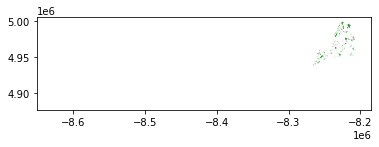

In [31]:
fig, ax=plt.subplots()
trails.plot(ax=ax, color='black')
parks.plot(ax=ax, color='g')
#the parks and trails don't line up. They also don't show up on the data page here so maybe this is a file issue: https://data.cityofnewyork.us/Environment/Parks-Trails/vjbm-hsyr

# Forestry

In [18]:
trees=pd.read_csv('S:/376/Spring22/jkchap16/Forestry_Tree_Points.csv')
trees.head()
# I didn't know what the crs was for the WKT column so I used the "Location" column instead

,OBJECTID,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,2249468,26.0,Full,Good,0.0,EE298162-61DE-4326-94CF-BAEADF67BBD2,POINT (1010086.2170835584 253833.11250019073),3CB519D4-82D6-4BF2-A893-F61C36D79D97,Quercus palustris - pin oak,01/05/2016 04:09:01 PM,10/18/2019 06:30:11 PM,NaN,7.0,10/18/2019 06:30:11 PM,"(40.86335012718705, -73.90659403804088)"
1,4609412,3.0,Retired,Excellent,NaN,NaN,NaN,7E64FD63-8FBF-4B6C-8E42-73CD6F965000,Quercus shumardii - Shumard's oak,10/27/2016 11:11:00 AM,09/04/2019 05:31:46 PM,06/28/2016 04:00:00 AM,NaN,NaN,NaN
2,1405530,30.0,Full,Fair,NaN,A3006528-1BB5-4B0D-AD98-31ABC173385A,POINT (1030435.7016668916 198098.22812518477),7AFC77DE-E6D9-4B4F-9C74-35B1C7581A90,Quercus palustris - pin oak,10/29/2015 01:16:28 PM,10/02/2019 05:46:25 PM,NaN,8.0,10/02/2019 05:46:25 PM,"(40.71029008261361, -73.83340766957191)"
3,4607742,3.0,Retired,Excellent,NaN,0C566EE4-669C-48F7-BDDD-FDE286065202,POINT (990456.88625022769 180979.589375183),C8D2B5C9-B418-46BB-9F55-4F0F359D7F8C,Quercus imbricaria - shingle oak,10/27/2016 11:11:00 AM,01/15/2019 03:25:00 PM,NaN,NaN,NaN,"(40.66342171188454, -73.97762743738365)"
4,2110343,5.0,Full,Good,0.0,9C8DB8A7-7437-4087-8F45-F76F4770CC54,POINT (982157.3310419023 204286.6170835197),603AE884-99BF-4D3D-978A-8C2BFF15044D,Quercus phellos - willow oak,01/05/2016 12:09:12 PM,10/28/2019 01:15:14 PM,NaN,3.0,10/28/2019 01:15:14 PM,"(40.72739601895657, -74.00755021282579)"


In [19]:
trees['Location']=trees['Location'].str.replace('(', '')
trees['Location']=trees['Location'].str.replace(')', '')
trees['long']= trees['Location'].str.split(',').str[0]
trees['lat']= trees['Location'].str.split(',').str[1]
trees['geometry2'] = gpd.points_from_xy(trees['long'].astype(float), trees['lat'].astype(float))

In [26]:
trees_gdf=gpd.GeoDataFrame(trees, geometry='geometry2', crs='EPSG:2263') #assuming this is using NAD83 not WGS84
trees_gdf.head()

,OBJECTID,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location,long,lat,geometry2
0,2249468,26.0,Full,Good,0.0,EE298162-61DE-4326-94CF-BAEADF67BBD2,POINT (1010086.2170835584 253833.11250019073),3CB519D4-82D6-4BF2-A893-F61C36D79D97,Quercus palustris - pin oak,01/05/2016 04:09:01 PM,10/18/2019 06:30:11 PM,NaN,7.0,10/18/2019 06:30:11 PM,"40.86335012718705, -73.90659403804088",40.86335012718705,-73.90659403804088,POINT (40.86335 -73.90659)
1,4609412,3.0,Retired,Excellent,NaN,NaN,NaN,7E64FD63-8FBF-4B6C-8E42-73CD6F965000,Quercus shumardii - Shumard's oak,10/27/2016 11:11:00 AM,09/04/2019 05:31:46 PM,06/28/2016 04:00:00 AM,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)
2,1405530,30.0,Full,Fair,NaN,A3006528-1BB5-4B0D-AD98-31ABC173385A,POINT (1030435.7016668916 198098.22812518477),7AFC77DE-E6D9-4B4F-9C74-35B1C7581A90,Quercus palustris - pin oak,10/29/2015 01:16:28 PM,10/02/2019 05:46:25 PM,NaN,8.0,10/02/2019 05:46:25 PM,"40.71029008261361, -73.83340766957191",40.71029008261361,-73.83340766957191,POINT (40.71029 -73.83341)
3,4607742,3.0,Retired,Excellent,NaN,0C566EE4-669C-48F7-BDDD-FDE286065202,POINT (990456.88625022769 180979.589375183),C8D2B5C9-B418-46BB-9F55-4F0F359D7F8C,Quercus imbricaria - shingle oak,10/27/2016 11:11:00 AM,01/15/2019 03:25:00 PM,NaN,NaN,NaN,"40.66342171188454, -73.97762743738365",40.66342171188454,-73.97762743738365,POINT (40.66342 -73.97763)
4,2110343,5.0,Full,Good,0.0,9C8DB8A7-7437-4087-8F45-F76F4770CC54,POINT (982157.3310419023 204286.6170835197),603AE884-99BF-4D3D-978A-8C2BFF15044D,Quercus phellos - willow oak,01/05/2016 12:09:12 PM,10/28/2019 01:15:14 PM,NaN,3.0,10/28/2019 01:15:14 PM,"40.72739601895657, -74.00755021282579",40.72739601895657,-74.00755021282579,POINT (40.72740 -74.00755)


In [27]:
trees_gdf=trees_gdf[(trees_gdf['TPStructure']=='Full') | (trees_gdf['Location'].notna())]

<AxesSubplot:>

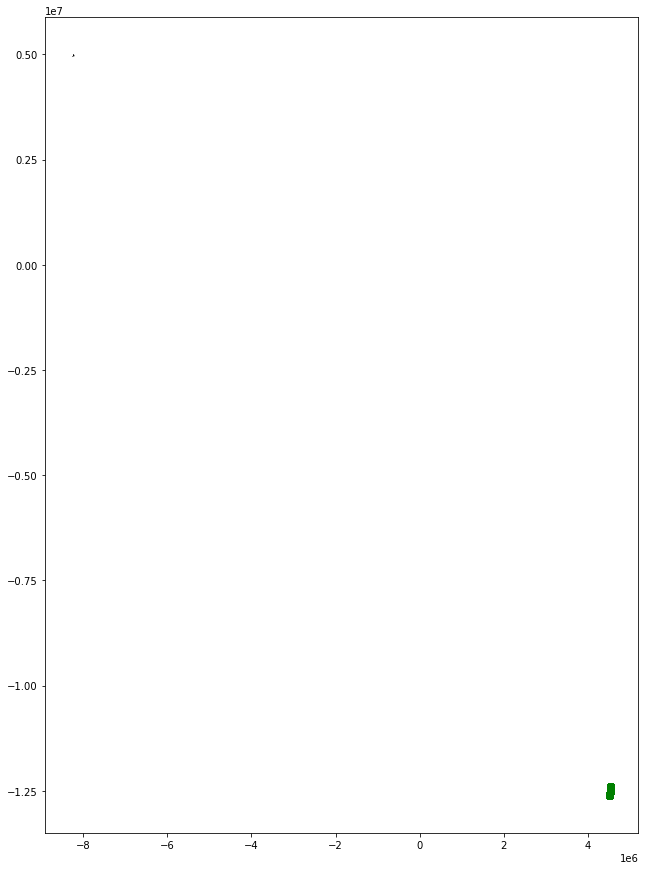

In [28]:
trees_gdf=trees_gdf.to_crs(epsg='3857')
fig, ax=plt.subplots(figsize=(15,15))
parks.plot(color='black', ax=ax)
trees_gdf.plot(color='green', ax=ax)
#They are also far off here
#See data here: https://data.cityofnewyork.us/Environment/Forestry-Tree-Points/hn5i-inap/data